In [55]:
# Import necessary libraries
import seaborn as sns
from faker import Faker
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Set the plotting style
sns.set(style='whitegrid')

# Initialize Faker for synthetic data generation
fake = Faker()
Faker.seed(42)

# Define products and time periods
products = ['Analytics', 'MachineLearning', 'WebHosting', 'IoT', 'Serverless']
time_periods = 6  # e.g., 6 months of data

# Assign relevant products to each customer type
customer_types = [
    {
        'name': 'Stable',
        'size': 'Medium',
        'spend_range': (10000, 50000),
        'growth_range': (-0.05, 0.05),
        'products': ['Analytics', 'WebHosting']
    },
    {
        'name': 'Growing',
        'size': 'Small',
        'spend_range': (5000, 20000),
        'growth_range': (0.1, 0.5),
        'products': ['Analytics', 'MachineLearning']
    },
    {
        'name': 'Declining',
        'size': 'Large',
        'spend_range': (30000, 100000),
        'growth_range': (-0.3, -0.1),
        'products': ['WebHosting', 'IoT']
    },
    {
        'name': 'Shifting',
        'size': 'Medium',
        'spend_range': (15000, 70000),
        'growth_range': (-0.2, 0.2),
        'products': ['Analytics', 'MachineLearning', 'Serverless']
    }
]

def generate_customer_data(n_customers):
    data = []
    for customer_id in range(1, n_customers + 1):
        customer_type = np.random.choice(customer_types)
        customer_base = {
            'CustomerID': customer_id,
            'CompanyName': fake.company(),
            'CompanySize': customer_type['size'],
            'CustomerType': customer_type['name'],
            'AssignedProducts': customer_type['products']  # Track assigned products
        }
        
        # Initialize current products for the customer
        current_products = set(customer_type['products'])
        
        # Generate data for each time period
        for period in range(time_periods):
            customer = customer_base.copy()
            customer['TimePeriod'] = period
            customer['TotalSpend'] = np.random.randint(*customer_type['spend_range'])
            
            # Generate product usage and growth
            total_growth = 0
            for product in products:
                if product not in current_products:
                    # Product not assigned to this customer; set usage and growth to 0
                    customer[f'{product}_Usage'] = 0
                    customer[f'{product}_Growth'] = 0
                    continue
                
                if period == 0:
                    # Initial usage
                    customer[f'{product}_Usage'] = np.random.randint(100, 1000)
                    customer[f'{product}_Growth'] = 0  # No growth for the first period
                else:
                    # Find the previous period's data for this customer
                    prev_customer_data = next(
                        item for item in reversed(data)
                        if item['CustomerID'] == customer_id and item['TimePeriod'] == period - 1
                    )
                    prev_usage = prev_customer_data[f'{product}_Usage']
                    
                    # Calculate new usage based on previous usage
                    change = np.random.uniform(*customer_type['growth_range'])
                    new_usage = max(0, int(prev_usage * (1 + change)))
                    customer[f'{product}_Usage'] = new_usage
                    
                    # Calculate growth
                    if prev_usage > 0:
                        customer[f'{product}_Growth'] = (new_usage - prev_usage) / prev_usage
                        total_growth += customer[f'{product}_Growth']
                    else:
                        customer[f'{product}_Growth'] = 0
                        total_growth += 0
            
            # Determine if the customer adopts a new product (for Shifting customers)
            if customer_type['name'] == 'Shifting' and period > 0:
                adopt_new = np.random.rand() < 0.3  # 30% chance to adopt a new product each period
                if adopt_new:
                    available_products = list(set(products) - current_products)
                    if available_products:
                        new_product = np.random.choice(available_products)
                        current_products.add(new_product)
                        customer['NewProductAdoption'] = new_product
                    else:
                        customer['NewProductAdoption'] = None
                else:
                    customer['NewProductAdoption'] = None
            else:
                customer['NewProductAdoption'] = None
            
            # Determine customer status
            if period > 0:
                customer['TotalGrowth'] = total_growth / len(current_products) if current_products else 0
                new_product_adoption = customer.get('NewProductAdoption') is not None
                significant_shift = abs(customer['TotalGrowth']) > 0.2
                
                if (customer_type['name'] == 'Declining' and customer['TotalGrowth'] < -0.1 and 
                    not new_product_adoption and not significant_shift):
                    customer['Status'] = 'Red Flag'
                elif new_product_adoption or (customer_type['name'] == 'Shifting' and significant_shift):
                    customer['Status'] = 'Shifting'
                elif customer['TotalGrowth'] > 0.1:
                    customer['Status'] = 'Growing'
                elif customer['TotalGrowth'] < -0.05:
                    customer['Status'] = 'Declining'
                else:
                    customer['Status'] = 'Stable'
            else:
                customer['Status'] = 'New'
                customer['TotalGrowth'] = 0
            
            data.append(customer)
    
    return pd.DataFrame(data)

# Generate synthetic customer data
n_customers = 1000
df = generate_customer_data(n_customers)

# Display the first few rows of the data
display(df.head())


,CustomerID,CompanyName,CompanySize,CustomerType,AssignedProducts,TimePeriod,TotalSpend,Analytics_Usage,Analytics_Growth,MachineLearning_Usage,MachineLearning_Growth,WebHosting_Usage,WebHosting_Growth,IoT_Usage,IoT_Growth,Serverless_Usage,Serverless_Growth,NewProductAdoption,Status,TotalGrowth
0,1,"Rodriguez, Figueroa and Sanchez",Medium,Stable,"[Analytics, WebHosting]",0,42703,202,0.000000,0,0.0,941,0.000000,0,0.0,0,0.0,None,New,0.000000
1,1,"Rodriguez, Figueroa and Sanchez",Medium,Stable,"[Analytics, WebHosting]",1,11907,204,0.009901,0,0.0,972,0.032944,0,0.0,0,0.0,None,Stable,0.021422
2,1,"Rodriguez, Figueroa and Sanchez",Medium,Stable,"[Analytics, WebHosting]",2,49872,201,-0.014706,0,0.0,966,-0.006173,0,0.0,0,0.0,None,Stable,-0.010439
3,1,"Rodriguez, Figueroa and Sanchez",Medium,Stable,"[Analytics, WebHosting]",3,25511,202,0.004975,0,0.0,930,-0.037267,0,0.0,0,0.0,None,Stable,-0.016146
4,1,"Rodriguez, Figueroa and Sanchez",Medium,Stable,"[Analytics, WebHosting]",4,37384,200,-0.009901,0,0.0,938,0.008602,0,0.0,0,0.0,None,Stable,-0.000649


,precision,recall,f1-score,support
0,0.943503,0.954286,0.948864,175.00
1,0.652174,0.600000,0.625000,25.00
accuracy,0.910000,0.910000,0.910000,0.91
macro avg,0.797838,0.777143,0.786932,200.00
weighted avg,0.907087,0.910000,0.908381,200.00


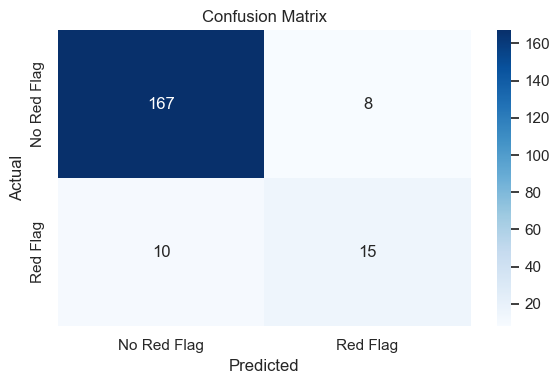

C:\Users\wesst\AppData\Local\Temp\ipykernel_38792\1886646381.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


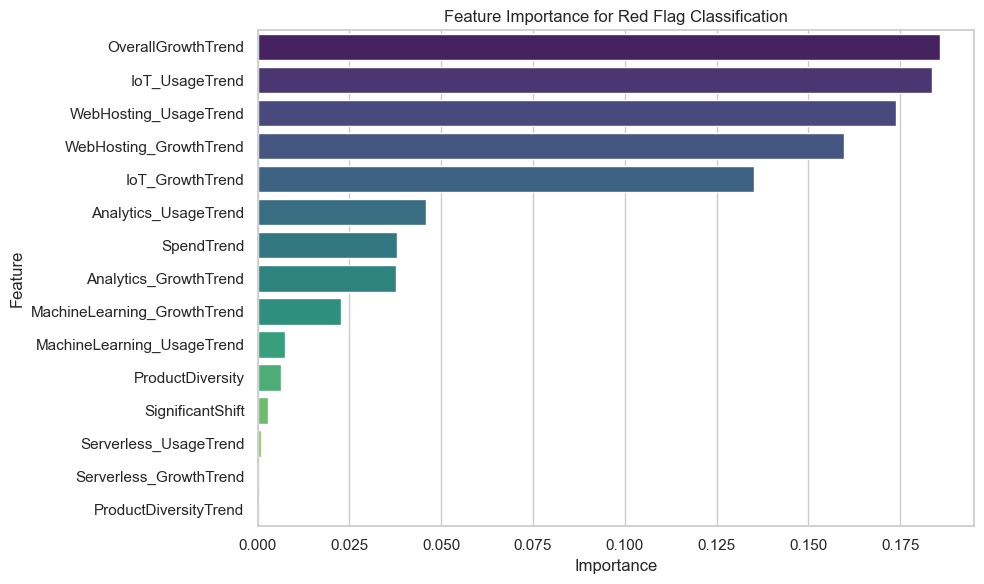

,Feature,Importance
10,OverallGrowthTrend,1.858234e-01
8,IoT_UsageTrend,1.835429e-01
7,WebHosting_UsageTrend,1.738712e-01
2,WebHosting_GrowthTrend,1.597667e-01
3,IoT_GrowthTrend,1.353278e-01
5,Analytics_UsageTrend,4.577828e-02
11,SpendTrend,3.792724e-02
0,Analytics_GrowthTrend,3.780544e-02
1,MachineLearning_GrowthTrend,2.261288e-02
6,MachineLearning_UsageTrend,7.567804e-03


In [56]:
# Feature engineering
def engineer_features(df):
    features = df.copy()
    
    # Calculate product-specific metrics
    for product in products:
        features[f'{product}_GrowthTrend'] = features.groupby('CustomerID')[f'{product}_Growth'].transform('mean')
        features[f'{product}_UsageTrend'] = features.groupby('CustomerID')[f'{product}_Usage'].transform(
            lambda x: x.pct_change().mean() if len(x) > 1 and x.iloc[0] > 0 else 0
        )
    
    # Calculate overall metrics
    features['OverallGrowthTrend'] = features.groupby('CustomerID')['TotalGrowth'].transform('mean')
    features['SpendTrend'] = features.groupby('CustomerID')['TotalSpend'].transform(
        lambda x: x.pct_change().mean() if len(x) > 1 and x.iloc[0] > 0 else 0
    )
    
    # Calculate product diversity based on assigned products
    features['ProductDiversity'] = features.groupby('CustomerID')['AssignedProducts'].transform(
        lambda x: len(set([prod for sublist in x for prod in (sublist if isinstance(sublist, list) else [sublist]) if prod]))
    )
    
    # Calculate diversity trend
    features['ProductDiversityTrend'] = features.groupby('CustomerID')['ProductDiversity'].transform(lambda x: x.diff().mean())
    
    # Identify significant shifts
    features['SignificantShift'] = ((features['OverallGrowthTrend'].abs() > 0.2) | (features['ProductDiversityTrend'] > 0)).astype(int)
    
    return features

# Prepare data for modeling
features = engineer_features(df)
features = features.groupby('CustomerID').last().reset_index()  # Use the latest data point for each customer

# Define target variable with improved logic
features['RedFlag'] = ((features['Status'] == 'Red Flag') & (features['SignificantShift'] == 0)).astype(int)

# Select features for the model
feature_cols = [f'{product}_GrowthTrend' for product in products] + \
               [f'{product}_UsageTrend' for product in products] + \
               ['OverallGrowthTrend', 'SpendTrend', 'ProductDiversity', 'ProductDiversityTrend', 'SignificantShift']

X = features[feature_cols]
y = features['RedFlag']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = clf.predict(X_test_scaled)

# Evaluate the model
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display classification report as a table
report_df = pd.DataFrame(report).transpose()
display(report_df)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Red Flag', 'Red Flag'],
            yticklabels=['No Red Flag', 'Red Flag'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': clf.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance for Red Flag Classification')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Display feature importance table
display(feature_importance)


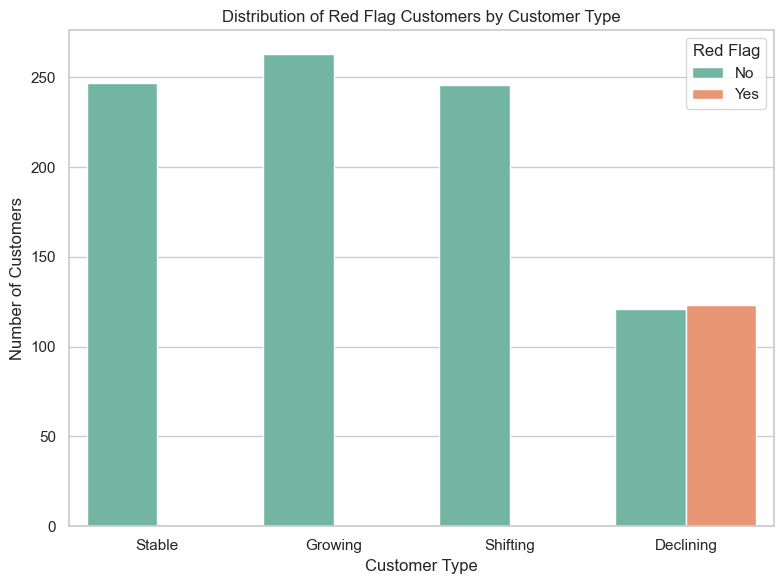

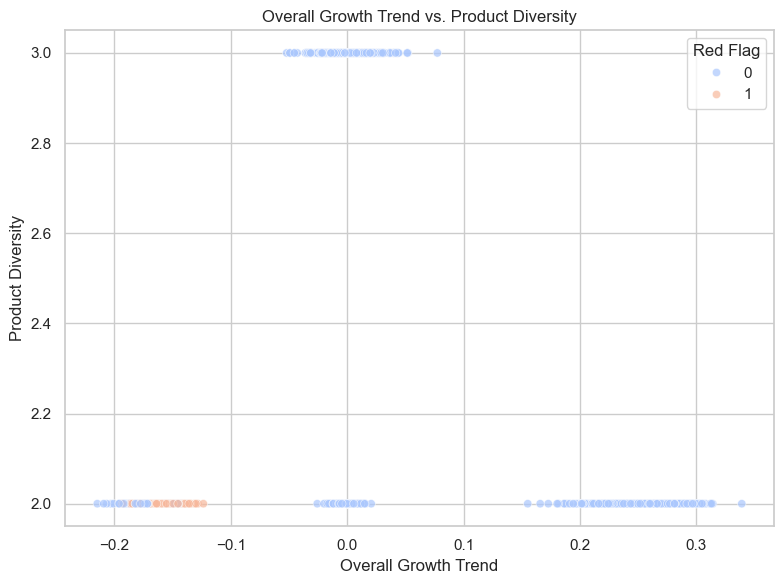

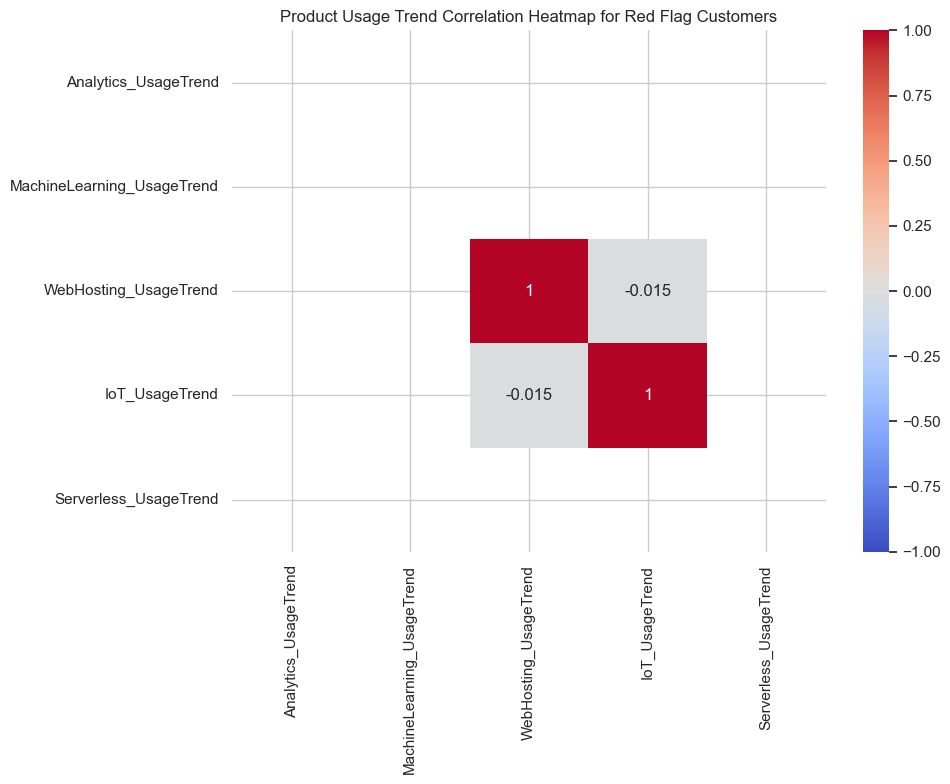

In [57]:
# Distribution of Red Flag Customers by Customer Type
def plot_red_flag_distribution(features):
    plt.figure(figsize=(8, 6))
    sns.countplot(x='CustomerType', hue='RedFlag', data=features, palette='Set2')
    plt.title('Distribution of Red Flag Customers by Customer Type')
    plt.xlabel('Customer Type')
    plt.ylabel('Number of Customers')
    plt.legend(title='Red Flag', labels=['No', 'Yes'])
    plt.tight_layout()
    plt.show()

plot_red_flag_distribution(features)

# Overall Growth Trend vs. Product Diversity
def plot_growth_vs_diversity(features):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='OverallGrowthTrend', y='ProductDiversity', hue='RedFlag', data=features, palette='coolwarm', alpha=0.7)
    plt.title('Overall Growth Trend vs. Product Diversity')
    plt.xlabel('Overall Growth Trend')
    plt.ylabel('Product Diversity')
    plt.legend(title='Red Flag')
    plt.tight_layout()
    plt.show()

plot_growth_vs_diversity(features)

# Product Usage Heatmap for Red Flag Customers
def plot_product_usage_heatmap(features):
    usage_cols = [f'{product}_UsageTrend' for product in products]
    usage_data = features[features['RedFlag'] == 1][usage_cols]

    plt.figure(figsize=(10, 8))
    if not usage_data.empty:
        sns.heatmap(usage_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Product Usage Trend Correlation Heatmap for Red Flag Customers')
    else:
        plt.text(0.5, 0.5, 'No Red Flag Customers to Display', horizontalalignment='center', verticalalignment='center')
        plt.title('Product Usage Trend Correlation Heatmap for Red Flag Customers')
    plt.tight_layout()
    plt.show()

plot_product_usage_heatmap(features)


In [58]:
# Business insights
total_customers = len(features)
num_red_flags = features['RedFlag'].sum()
percentage_red_flags = (num_red_flags / total_customers) * 100

print("\nBusiness Insights:")
print(f"1. **Total Customers Analyzed**: {total_customers}")
print(f"2. **Number of Red Flag Customers**: {num_red_flags} ({percentage_red_flags:.2f}%)")
print(f"3. **Average Product Diversity among Red Flags**: {features[features['RedFlag'] == 1]['ProductDiversity'].mean():.2f}")
print(f"4. **Most Common Customer Type among Red Flags**: {features[features['RedFlag'] == 1]['CustomerType'].mode().values[0]}")
print(f"5. **Percentage of Red Flags with Significant Shifts**: {(features[features['RedFlag'] == 1]['SignificantShift'].mean() * 100):.2f}%")

# Recommendations
print("\nRecommendations:")
print("1. **Targeted Retention Efforts:** Focus on Declining customers as they are the most common among red flags.")
print("2. **Enhance Product Diversity:** Encourage customers, especially Stable and Declining types, to adopt additional products to increase their Product Diversity.")
print("3. **Monitor Shifting Customers:** Keep a close watch on Shifting customers who are adopting new products to ensure their growth remains positive.")
print("4. **Engagement Strategies:** Develop tailored engagement strategies for customers showing declining growth trends to prevent churn.")
print("5. **Leverage High-Demand Workloads:** Promote high computational demand products to increase customer reliance and reduce the likelihood of them becoming red flags.")



Business Insights:
1. **Total Customers Analyzed**: 1000
2. **Number of Red Flag Customers**: 123 (12.30%)
3. **Average Product Diversity among Red Flags**: 2.00
4. **Most Common Customer Type among Red Flags**: Declining
5. **Percentage of Red Flags with Significant Shifts**: 0.00%

Recommendations:
1. **Targeted Retention Efforts:** Focus on Declining customers as they are the most common among red flags.
2. **Enhance Product Diversity:** Encourage customers, especially Stable and Declining types, to adopt additional products to increase their Product Diversity.
3. **Monitor Shifting Customers:** Keep a close watch on Shifting customers who are adopting new products to ensure their growth remains positive.
4. **Engagement Strategies:** Develop tailored engagement strategies for customers showing declining growth trends to prevent churn.
5. **Leverage High-Demand Workloads:** Promote high computational demand products to increase customer reliance and reduce the likelihood of them be

In [59]:
# Total number of customers
total_customers = len(features)

# Number of red flag customers
num_red_flags = features['RedFlag'].sum()

# Percentage of red flag customers
percentage_red_flags = (num_red_flags / total_customers) * 100

print(f"Total Customers Analyzed: {total_customers}")
print(f"Number of Red Flag Customers: {num_red_flags} ({percentage_red_flags:.2f}%)")


Total Customers Analyzed: 1000
Number of Red Flag Customers: 123 (12.30%)


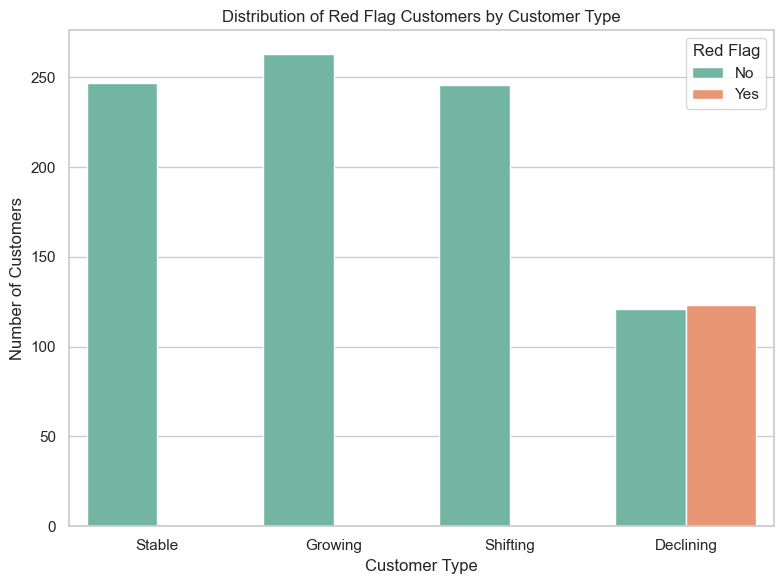

In [60]:
plt.figure(figsize=(8, 6))
sns.countplot(x='CustomerType', hue='RedFlag', data=features, palette='Set2')
plt.title('Distribution of Red Flag Customers by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Number of Customers')
plt.legend(title='Red Flag', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


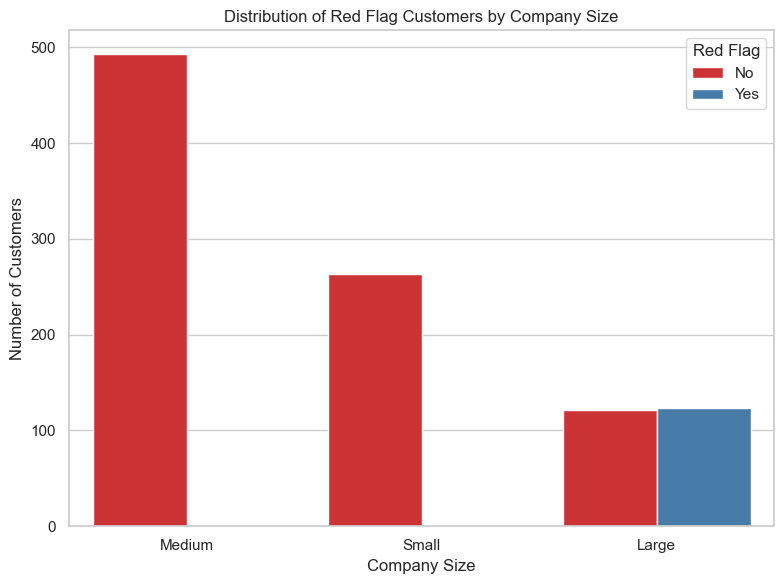

In [61]:
plt.figure(figsize=(8, 6))
sns.countplot(x='CompanySize', hue='RedFlag', data=features, palette='Set1')
plt.title('Distribution of Red Flag Customers by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Number of Customers')
plt.legend(title='Red Flag', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


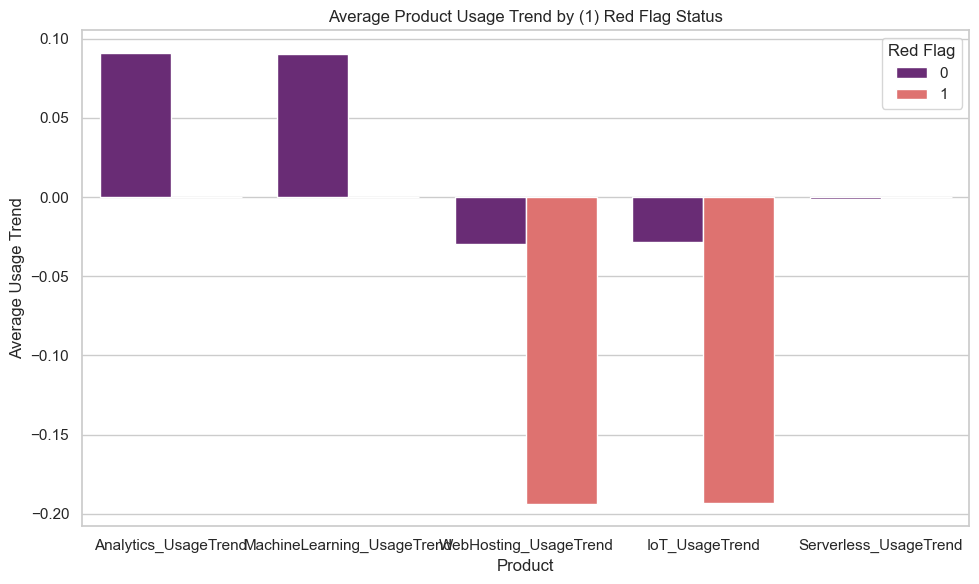

In [62]:
# List of usage trend columns
usage_trends = [f'{product}_UsageTrend' for product in products]

# Calculate average usage for red flag and non-red flag customers
avg_usage = features.groupby('RedFlag')[usage_trends].mean().reset_index()

# Melt the DataFrame for easier plotting
avg_usage_melted = avg_usage.melt(id_vars='RedFlag', var_name='Product', value_name='AverageUsage')

plt.figure(figsize=(10, 6))
sns.barplot(x='Product', y='AverageUsage', hue='RedFlag', data=avg_usage_melted, palette='magma')
plt.title('Average Product Usage Trend by (1) Red Flag Status')
plt.xlabel('Product')
plt.ylabel('Average Usage Trend')
plt.legend(title='Red Flag')
plt.tight_layout()
plt.show()


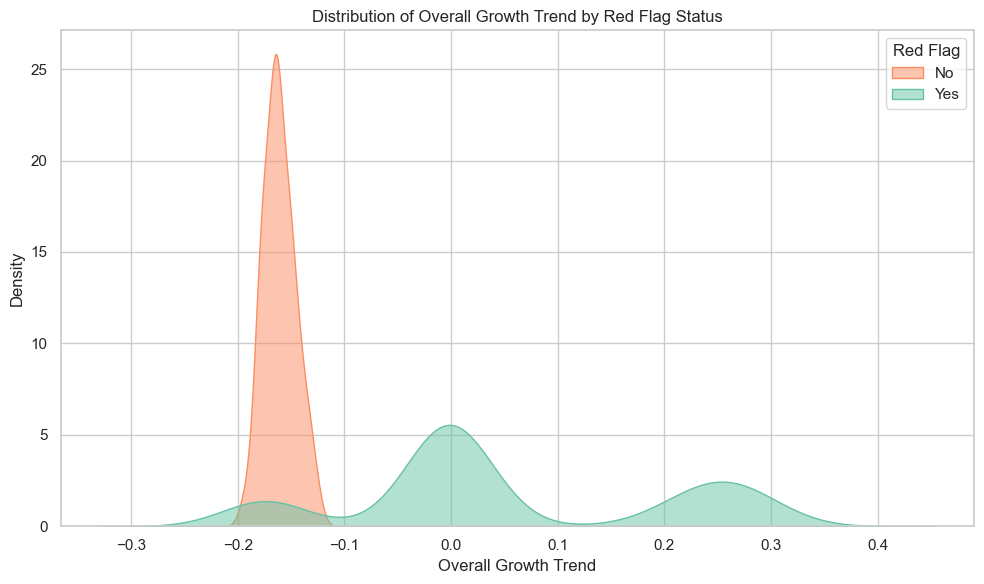

In [63]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=features, x='OverallGrowthTrend', hue='RedFlag', fill=True, common_norm=False, palette='Set2', alpha=0.5)
plt.title('Distribution of Overall Growth Trend by Red Flag Status')
plt.xlabel('Overall Growth Trend')
plt.ylabel('Density')
plt.legend(title='Red Flag', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


In [64]:
def analyze_top_red_flags(features, n=5):
    # Select red flag customers
    red_flags = features[features['RedFlag'] == 1]
    
    # Sort by OverallGrowthTrend (most negative first)
    top_red_flags = red_flags.sort_values('OverallGrowthTrend').head(n)
    
    print(f"\nTop {n} Red Flag Customers with Lowest Overall Growth Trend:")
    display(top_red_flags[['CustomerID', 'CompanyName', 'CustomerType', 'OverallGrowthTrend', 
                           'ProductDiversity', 'ProductDiversityTrend', 'SignificantShift'] + usage_trends])
    
    # Detailed analysis
    for _, row in top_red_flags.iterrows():
        customer_id = row['CustomerID']
        print(f"\n---\n**Customer ID:** {customer_id}")
        print(f"**Company Name:** {row['CompanyName']}")
        print(f"**Customer Type:** {row['CustomerType']}")
        print(f"**Overall Growth Trend:** {row['OverallGrowthTrend']:.2%}")
        print(f"**Product Diversity:** {row['ProductDiversity']}")
        print(f"**Product Diversity Trend:** {row['ProductDiversityTrend']:.2f}")
        print(f"**Significant Shift:** {'Yes' if row['SignificantShift'] == 1 else 'No'}")
        print("**Product Usage Trends:**")
        for product in products:
            usage = row[f'{product}_UsageTrend']
            print(f"  - {product}: {usage:.2%}")


# Analyze top 5 red flag customers
analyze_top_red_flags(features, n=5)




Top 5 Red Flag Customers with Lowest Overall Growth Trend:


,CustomerID,CompanyName,CustomerType,OverallGrowthTrend,ProductDiversity,ProductDiversityTrend,SignificantShift,Analytics_UsageTrend,MachineLearning_UsageTrend,WebHosting_UsageTrend,IoT_UsageTrend,Serverless_UsageTrend
357,358,"Williams, Logan and Camacho",Declining,-0.194712,2,0.0,0,0.0,0.0,-0.242082,-0.225226,0.0
926,927,Brady LLC,Declining,-0.193198,2,0.0,0,0.0,0.0,-0.216053,-0.247622,0.0
311,312,Parsons-Hall,Declining,-0.187228,2,0.0,0,0.0,0.0,-0.229806,-0.219542,0.0
752,753,Davis and Sons,Declining,-0.186054,2,0.0,0,0.0,0.0,-0.211314,-0.235215,0.0
877,878,Khan LLC,Declining,-0.184551,2,0.0,0,0.0,0.0,-0.229382,-0.213541,0.0



---
**Customer ID:** 358
**Company Name:** Williams, Logan and Camacho
**Customer Type:** Declining
**Overall Growth Trend:** -19.47%
**Product Diversity:** 2
**Product Diversity Trend:** 0.00
**Significant Shift:** No
**Product Usage Trends:**
  - Analytics: 0.00%
  - MachineLearning: 0.00%
  - WebHosting: -24.21%
  - IoT: -22.52%
  - Serverless: 0.00%

---
**Customer ID:** 927
**Company Name:** Brady LLC
**Customer Type:** Declining
**Overall Growth Trend:** -19.32%
**Product Diversity:** 2
**Product Diversity Trend:** 0.00
**Significant Shift:** No
**Product Usage Trends:**
  - Analytics: 0.00%
  - MachineLearning: 0.00%
  - WebHosting: -21.61%
  - IoT: -24.76%
  - Serverless: 0.00%

---
**Customer ID:** 312
**Company Name:** Parsons-Hall
**Customer Type:** Declining
**Overall Growth Trend:** -18.72%
**Product Diversity:** 2
**Product Diversity Trend:** 0.00
**Significant Shift:** No
**Product Usage Trends:**
  - Analytics: 0.00%
  - MachineLearning: 0.00%
  - WebHosting: -22.98%
 

In [65]:
features['SignificantShift'].value_counts()

SignificantShift
0    744
1    256
Name: count, dtype: int64